In [1]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import logging

In [2]:
# Setting up logging configuration
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
)

In [16]:
# Reading the input data in csv format
if os.path.isfile("input_data.csv"):
    data = pd.read_csv("input_data.csv")
else:
    logging.error("'input_data.csv' does not exist in the current directory.")
    exit(1)

In [17]:
# Converting SMILES notations to molecular objects
mol_list = []
for mol_smile in data["SMILES"]:
    mol = Chem.MolFromSmiles(mol_smile)
    if not mol:
        logging.warning(f"Unable to convert {mol_smile} to Mol object.")
    else:
        mol_list.append(mol)

In [18]:
# Generating 2D and 3D molecular descriptors
des_list = []
for mol in mol_list:
    # 2D descriptors
    desc_2D = [
        Descriptors.MolLogP(mol),
        Descriptors.MolMR(mol),
        Descriptors.TPSA(mol),
        Descriptors.NOCount(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumValenceElectrons(mol),
    ]
    
    des_list.append(desc_2D)
    # print(des_list)
    
"""
    # 3D descriptors
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol)
        desc_3D = [Descriptors.MolVolume(mol), Descriptors.CalcTPSA(mol)]
    except:
        logging.warning(f"Descriptor calculation failed for something in {mol}. Check for any special characters.")

    # Combining 2D and 3D descriptors
    des = desc_2D + desc_3D
    des_list.append(des) """

'\n    # 3D descriptors\n    try:\n        mol = Chem.AddHs(mol)\n        AllChem.EmbedMolecule(mol)\n        AllChem.MMFFOptimizeMolecule(mol)\n        desc_3D = [Descriptors.MolVolume(mol), Descriptors.CalcTPSA(mol)]\n    except:\n        logging.warning(f"Descriptor calculation failed for something in {mol}. Check for any special characters.")\n\n    # Combining 2D and 3D descriptors\n    des = desc_2D + desc_3D\n    des_list.append(des) '

In [19]:
# Converting descriptor lists to dataframe
descriptors = pd.DataFrame(des_list)

In [20]:
# Merging the descriptor dataframe with activity data
activity = data["Activity"]
data_new = pd.concat([activity, descriptors], axis=1)

In [21]:
# Splitting the data into training and testing sets
X = data_new.iloc[:, 1:]
y = data_new.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
# Training the linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
# Predicting the IC50 values using the test set
y_pred = lr.predict(X_test)

In [24]:
# Calculating the regression coefficient (R2) and root mean square error (RMSE)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [25]:
# Calculating the cross-validation (R2predict)
r2p = np.mean(cross_val_score(lr, X, y, cv=10))

In [26]:
# Creating the output directory if it doesn't exist
os.makedirs("output", exist_ok=True)

In [49]:
both = y_test + y_pred

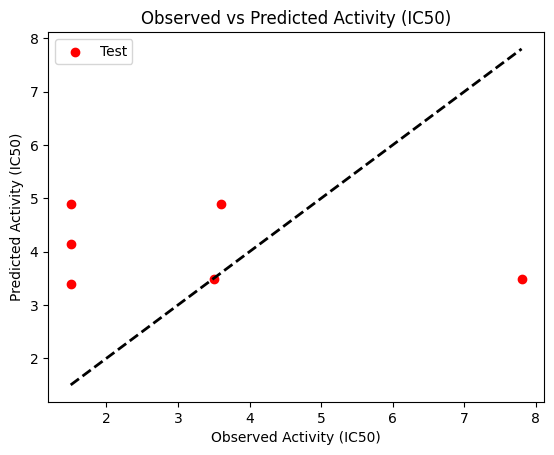

In [58]:
# Plotting the Observed vs predicted activity graph from the model and saving in png file
plt.scatter(y_test, y_pred, color=["red"])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Observed Activity (IC50)")
plt.ylabel("Predicted Activity (IC50)")
plt.title("Observed vs Predicted Activity (IC50)")
plt.savefig("output/obs_vs_pred.png")
plt.legend(["Test"])
plt.show()

In [28]:
# Exporting the Observed vs Predicted activity values as csv to current directory
df_result = pd.DataFrame({'Observed_Activity': y_test, 'Predicted_Activity': y_pred})
df_result.to_csv('obs_vs_pred.csv', index=False)

In [29]:
# Printing the R2, R2predict and RMSE values
print("Linear Regression R2: %.2f" % r2)
print("Cross-Validation R2: %.2f" % r2p)
print("Linear Regression RMSE: %.2f" % rmse)

Linear Regression R2: -0.41
Cross-Validation R2: -2.03
Linear Regression RMSE: 2.66


This code will generate output for regression coefficient (R2), cross-validation (R2predict) and root mean square error (RMSE).

Note: As the size of the dataset is unknown here, there would be approximations involved. You can adjust them according to your dataset size.